In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import math
import seaborn as sns

from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes import jtplot

In [2]:
filename_stars = "hygdata_v3.csv"

stars_df = pd.read_csv(filename_stars)
stars_df = stars_df[["id", "proper", "lum", "spect", "ci", "comp", "comp_primary", "x", "y", "z", "absmag"]]

stars_df = stars_df[stars_df["ci"].notnull()]
stars_df.shape

(117732, 11)

In [3]:
stars_df["StarSpectralTypeLetter"] = stars_df["spect"].str.extract("([OBAFGKM])[0-9].*")
stars_df["StarSpectralTypeNumber"] = stars_df["spect"].str.extract("[OBAFGKM]([0-9]).*")
# stars_df["star_HR_type"] =  stars_df["spect"].str.extract("[OBAFGKM][0-9][\s\-\d\.]?([IV]+)")
stars_df["StarHRType"] =  stars_df["spect"].str.extract("[OBAFGKM][0-9][^\w]?([IV]+)")

stars_df["mass_approx"] = stars_df["lum"].pow(3.5)

# stars_df["temp_calculated_2"] =  (5000 / (stars_df["ci"] + 1.84783)) + (5000 / (stars_df["ci"] + .673913))
stars_df["temp_calculated"] = 4600*(1/(0.92*stars_df["ci"]+1.7) + 1/(0.92*stars_df["ci"]+0.62))
# stars_df["radius"] = stars_df["lum"] * 7.35355e-8 * (5.778 / 3.828e+26) * stars_df["temp_calculated"] # in solar radii

solar_temp = stars_df[stars_df["proper"] == "Sol"]["temp_calculated"].iloc[0]
print(solar_temp)
stars_df["radius"] = solar_temp*solar_temp/stars_df["temp_calculated"].pow(2) * (stars_df["lum"].pow(0.5))


5756.588112693915


In [4]:
stars_plotted = stars_df[stars_df["StarHRType"].notna()]
stars_plotted.shape


(54786, 17)

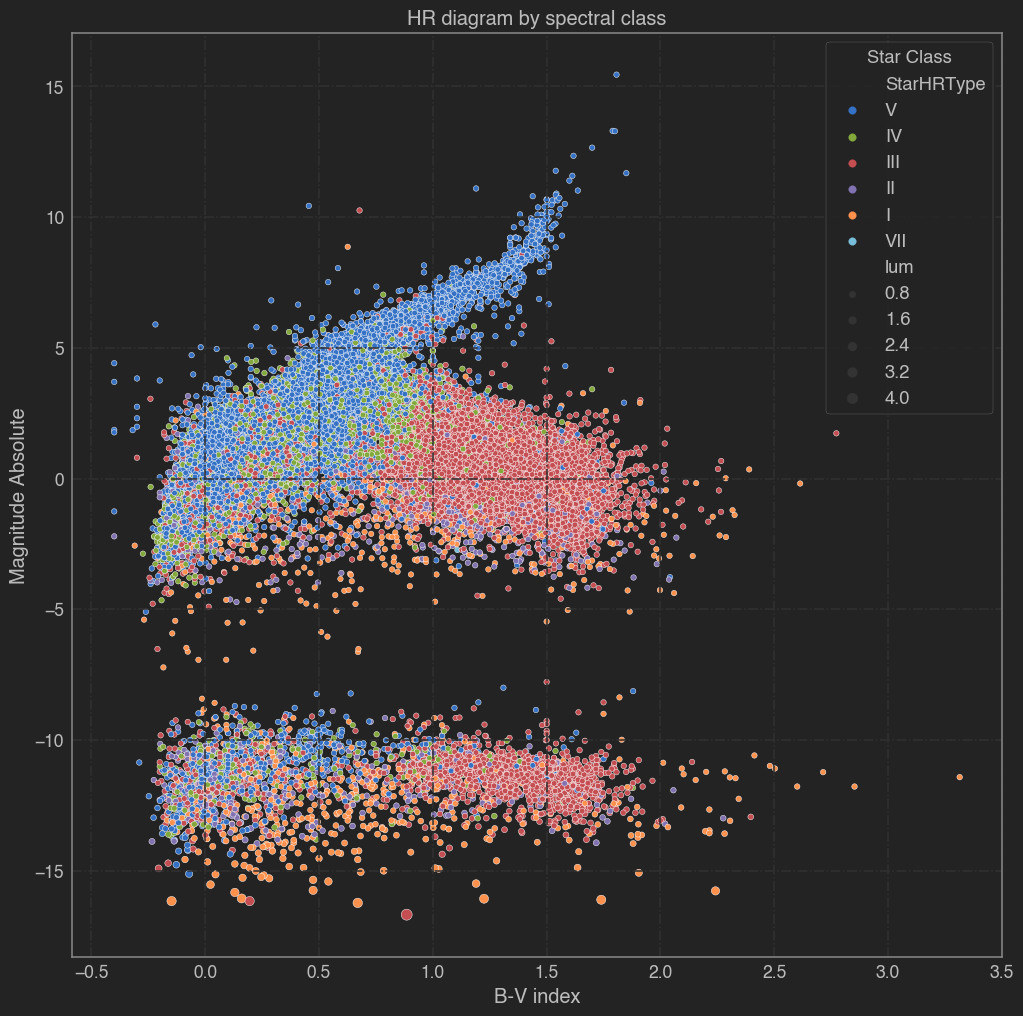

In [5]:
jtplot.style(theme='monokai', gridlines= '-.',figsize=(15,15))

sns.scatterplot(data = stars_plotted, x = 'ci', y = 'absmag', hue="StarHRType", size="lum")
plt.title('HR diagram by spectral class')
plt.legend(title = 'Star Class', fontsize = 'medium', title_fontsize = 'medium')

plt.xlabel('B-V index')
plt.ylabel('Magnitude Absolute')

plt.tight_layout
plt.show()

In [6]:
def bv2rgb(bv):
    # bv is the B-V colour index of a star

    t = (5000 / (bv + 1.84783)) + (5000 / (bv + .673913))
    # t is the temperature of the star

    x, y = 0, 0
    
    if 1667 <= t <= 4000:
        x = .17991 - (2.66124e8 / t**3) - (234358 / t**2) + (877.696 / t)
    elif 4000 < t:
        x = .24039 - (3.02585e9 / t**3) + (2.10704e6 / t**2) + (222.635 / t)
        
    if 1667 <= t <= 2222:
        y = (-1.1063814 * x**3) - (1.34811020 * x**2) + 2.18555832 * x - .20219683
    elif 2222 < t <= 4000:
        y = (-.9549476 * x**3) - (1.37418593 * x**2) + 2.09137015 * x - .16748867
    elif 4000 < t:
        y = (3.0817580 * x**3) - (5.87338670 * x**2) + 3.75112997 * x - .37001483
        
    X = 0 if y == 0 else x / y
    Z = 0 if y == 0 else (1 - x - y) / y
    
    r, g, b = np.dot([X, 1., Z],
        [[3.2406, -.9689, .0557], [-1.5372, 1.8758, -.204], [-.4986, .0415, 1.057]])
    
    R = np.clip(12.92 * r if (r <= 0.0031308) else 1.4 * (r**2 - .285714), 0, 1)
    G = np.clip(12.92 * g if (g <= 0.0031308) else 1.4 * (g**2 - .285714), 0, 1)
    B = np.clip(12.92 * b if (b <= 0.0031308) else 1.4 * (b**2 - .285714), 0, 1)
    
    return [R, G, B]

stars_df["colors"] = stars_df['ci'].apply(bv2rgb)
# Use this temperature to determine the stars spectral class!

stars_df["Red"] = stars_df["colors"].str[0]
stars_df["Green"] = stars_df["colors"].str[1]
stars_df["Blue"] = stars_df["colors"].str[2]

In [7]:
stars_df = stars_df[stars_df["StarHRType"].notna()]

rename_mapper = {"id":"ID", "proper":"ProperName", "lum":"Luminosity", "spect":"Spect", "comp_primary":"CompPrimary", "x":"PosX", "y":"PosY", "z":"PosZ", "absmag":"AbsMag"}

stars_df = stars_df.rename(columns = rename_mapper)

print(stars_df)
stars_df.to_csv("StarDatabase.csv")

            ID ProperName  Luminosity Spect     ci  comp  CompPrimary  \
0        13735        NaN    0.432912   K2V  0.960     3        13738   
27      119060        NaN    0.620012  G8 V  0.750     3       119058   
41        2843        NaN    0.743361   K0V  0.780     2         2883   
42        7736        NaN    0.264728   K0V  0.880     2       118084   
49       33981        NaN    0.700810   K0V  0.779     2        33977   
...        ...        ...         ...   ...    ...   ...          ...   
119312  119193        NaN    0.430923  K0 V  0.790     1       119193   
119375  119271        NaN    1.084426  G6 V  0.650     1       119271   
119416  119336        NaN    0.342295  G8 V  0.860     1       119336   
119490  119445        NaN    0.179639  K3 V  1.040     1       119445   
119530  119501        NaN    1.152391  G3 V  0.620     1       119501   

             PosX       PosY       PosZ  ...  StarSpectralTypeLetter  \
0       16.915907  16.510396 -11.009949  ...       

In [8]:
#stars_df.style.set_sticky(1).set_sticky(0)

# print(stars_df["x"].max())
# print(stars_df["x"].min())

# print(stars_df["y"].max())
# print(stars_df["y"].min())

# print(stars_df["z"].max())
# print(stars_df["z"].min())

# stars_df.columns